In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import json

from dateutil.parser import isoparser

In [2]:
posts_df = pd.read_csv('cleaned_posts.csv')

# Convert date to datetime
posts_df['date'] = posts_df['date'].astype('string')
posts_df['date'] = posts_df['date'].apply(lambda x : isoparser().isoparse(x) if pd.notnull(x) else pd.NaT)

posts_df = posts_df[['date', 'sentiment']]

# If sentiment is 1, set positive to 1
posts_df['positive'] = posts_df['sentiment'].apply(lambda x : 1 if x == 1 else 0)
posts_df['negative'] = posts_df['sentiment'].apply(lambda x : 1 if x == -1 else 0)
posts_df['neutral'] = posts_df['sentiment'].apply(lambda x : 1 if x == 0 else 0)
posts_df['post'] = 1


In [3]:
posts_group_df = posts_df
posts_group_df = posts_group_df.groupby(pd.Grouper(key='date', freq='30Min')).sum()

posts_group_df = posts_group_df.reset_index()

# Drop all row outside the trading days (Monday - Friday)
posts_group_df = posts_group_df[posts_group_df['date'].dt.weekday < 5]

# Drop all row outside trading hours (9:00 - 11:30, 13:00 - 15:00)
posts_group_df = posts_group_df[posts_group_df['date'].dt.time >= pd.to_datetime('09:00').time()]
posts_group_df = posts_group_df[posts_group_df['date'].dt.time < pd.to_datetime('15:00').time()]
posts_group_df = posts_group_df[posts_group_df['date'].dt.hour != 12]
posts_group_df = posts_group_df[posts_group_df['date'].dt.time != pd.to_datetime('11:30').time()]

posts_group_df = posts_group_df.reset_index(drop=True)


In [4]:
# rename post to m_CntAll, sentiment to m_PN
posts_group_df = posts_group_df.rename(columns={'post':'num_CntAll', 'sentiment':'num_PN'})
posts_group_df['r_PosPN'] = posts_group_df['positive']/(posts_group_df['positive']+posts_group_df['negative'])
posts_group_df['r_PosAll'] = posts_group_df['positive']/(posts_group_df['num_CntAll'])
posts_group_df['r_NeuAll'] = posts_group_df['neutral']/(posts_group_df['num_CntAll'])

# find the rolling mean of the sentiment
posts_group_df['m_1d_PN'] = posts_group_df['num_PN'].rolling(window=9).mean()
posts_group_df['m_1d_PosPN'] = posts_group_df['r_PosPN'].rolling(window=9).mean()
posts_group_df['m_1d_CntAll'] = posts_group_df['num_CntAll'].rolling(window=9).mean()

posts_group_df['m_2h_PN'] = posts_group_df['num_PN'].rolling(window=4).mean()
posts_group_df['m_2h_PosPN'] = posts_group_df['r_PosPN'].rolling(window=4).mean()
posts_group_df['m_2h_CntAll'] = posts_group_df['num_CntAll'].rolling(window=4).mean()

posts_group_df.head(30)

,date,num_PN,positive,negative,neutral,num_CntAll,r_PosPN,r_PosAll,r_NeuAll,m_1d_PN,m_1d_PosPN,m_1d_CntAll,m_2h_PN,m_2h_PosPN,m_2h_CntAll
0,2024-09-06 09:30:00+07:00,3,8,5,71,84,0.615385,0.095238,0.845238,NaN,NaN,NaN,NaN,NaN,NaN
1,2024-09-06 10:00:00+07:00,12,32,20,352,404,0.615385,0.079208,0.871287,NaN,NaN,NaN,NaN,NaN,NaN
2,2024-09-06 10:30:00+07:00,-4,23,27,389,439,0.460000,0.052392,0.886105,NaN,NaN,NaN,NaN,NaN,NaN
3,2024-09-06 11:00:00+07:00,4,37,33,354,424,0.528571,0.087264,0.834906,NaN,NaN,NaN,3.75,0.554835,337.75
4,2024-09-06 13:00:00+07:00,13,28,15,392,435,0.651163,0.064368,0.901149,NaN,NaN,NaN,6.25,0.563780,425.50
5,2024-09-06 13:30:00+07:00,12,34,22,469,525,0.607143,0.064762,0.893333,NaN,NaN,NaN,6.25,0.561719,455.75
6,2024-09-06 14:00:00+07:00,35,63,28,606,697,0.692308,0.090387,0.869440,NaN,NaN,NaN,16.00,0.619796,520.25
7,2024-09-06 14:30:00+07:00,15,29,14,422,465,0.674419,0.062366,0.907527,NaN,NaN,NaN,18.75,0.656258,530.50
8,2024-09-09 09:00:00+07:00,37,57,20,346,423,0.740260,0.134752,0.817967,14.111111,0.620515,432.888889,24.75,0.678532,527.50
9,2024-09-09 09:30:00+07:00,21,41,20,423,484,0.672131,0.084711,0.873967,16.111111,0.626820,477.333333,27.00,0.694779,517.25


In [5]:
price_vnindex_df = pd.read_csv('price/VNINDEX.csv')

price_vnindex_df['date'] = pd.to_datetime(price_vnindex_df['time'], format='%Y-%m-%d %H:%M:%S', errors='coerce').dt.tz_localize('Asia/Ho_Chi_Minh')

price_vnindex_df = price_vnindex_df.drop(columns=['time'])

price_vnindex_df.head(20)

,open,high,low,close,volume,date
0,1273.86,1273.86,1268.53,1271.34,76561000,2024-09-04 09:00:00+07:00
1,1270.47,1277.27,1270.47,1276.68,90341400,2024-09-04 09:30:00+07:00
2,1276.84,1277.01,1273.03,1273.30,52188000,2024-09-04 10:00:00+07:00
3,1273.26,1273.28,1270.78,1270.98,48367900,2024-09-04 10:30:00+07:00
4,1271.14,1272.22,1270.54,1270.92,57640500,2024-09-04 11:00:00+07:00
5,1270.93,1270.96,1270.93,1270.96,51900,2024-09-04 11:30:00+07:00
6,1270.77,1271.25,1268.43,1271.13,84774900,2024-09-04 13:00:00+07:00
7,1271.03,1273.62,1270.84,1272.56,86154900,2024-09-04 13:30:00+07:00
8,1272.51,1276.43,1272.07,1276.01,107648224,2024-09-04 14:00:00+07:00
9,1276.14,1276.14,1275.80,1275.80,33469900,2024-09-04 14:30:00+07:00


In [6]:
merged_df = pd.merge(posts_group_df, price_vnindex_df, on='date', how='left')
merged_df.head(20)

,date,num_PN,positive,negative,neutral,num_CntAll,r_PosPN,r_PosAll,r_NeuAll,m_1d_PN,m_1d_PosPN,m_1d_CntAll,m_2h_PN,m_2h_PosPN,m_2h_CntAll,open,high,low,close,volume
0,2024-09-06 09:30:00+07:00,3,8,5,71,84,0.615385,0.095238,0.845238,NaN,NaN,NaN,NaN,NaN,NaN,1267.04,1269.06,1266.03,1268.90,47701500
1,2024-09-06 10:00:00+07:00,12,32,20,352,404,0.615385,0.079208,0.871287,NaN,NaN,NaN,NaN,NaN,NaN,1269.06,1269.48,1267.51,1267.95,86709118
2,2024-09-06 10:30:00+07:00,-4,23,27,389,439,0.460000,0.052392,0.886105,NaN,NaN,NaN,NaN,NaN,NaN,1267.84,1267.91,1264.96,1265.38,50314500
3,2024-09-06 11:00:00+07:00,4,37,33,354,424,0.528571,0.087264,0.834906,NaN,NaN,NaN,3.75,0.554835,337.75,1265.42,1265.42,1263.50,1264.31,52608200
4,2024-09-06 13:00:00+07:00,13,28,15,392,435,0.651163,0.064368,0.901149,NaN,NaN,NaN,6.25,0.563780,425.50,1263.67,1267.01,1262.94,1266.27,86647800
5,2024-09-06 13:30:00+07:00,12,34,22,469,525,0.607143,0.064762,0.893333,NaN,NaN,NaN,6.25,0.561719,455.75,1266.50,1269.73,1265.92,1267.69,105859600
6,2024-09-06 14:00:00+07:00,35,63,28,606,697,0.692308,0.090387,0.869440,NaN,NaN,NaN,16.00,0.619796,520.25,1267.67,1274.44,1267.67,1273.00,102918300
7,2024-09-06 14:30:00+07:00,15,29,14,422,465,0.674419,0.062366,0.907527,NaN,NaN,NaN,18.75,0.656258,530.50,1272.68,1273.96,1272.68,1273.96,55023400
8,2024-09-09 09:00:00+07:00,37,57,20,346,423,0.740260,0.134752,0.817967,14.111111,0.620515,432.888889,24.75,0.678532,527.50,1273.96,1273.96,1264.83,1266.77,54319078
9,2024-09-09 09:30:00+07:00,21,41,20,423,484,0.672131,0.084711,0.873967,16.111111,0.626820,477.333333,27.00,0.694779,517.25,1266.76,1269.53,1266.29,1268.38,70100800


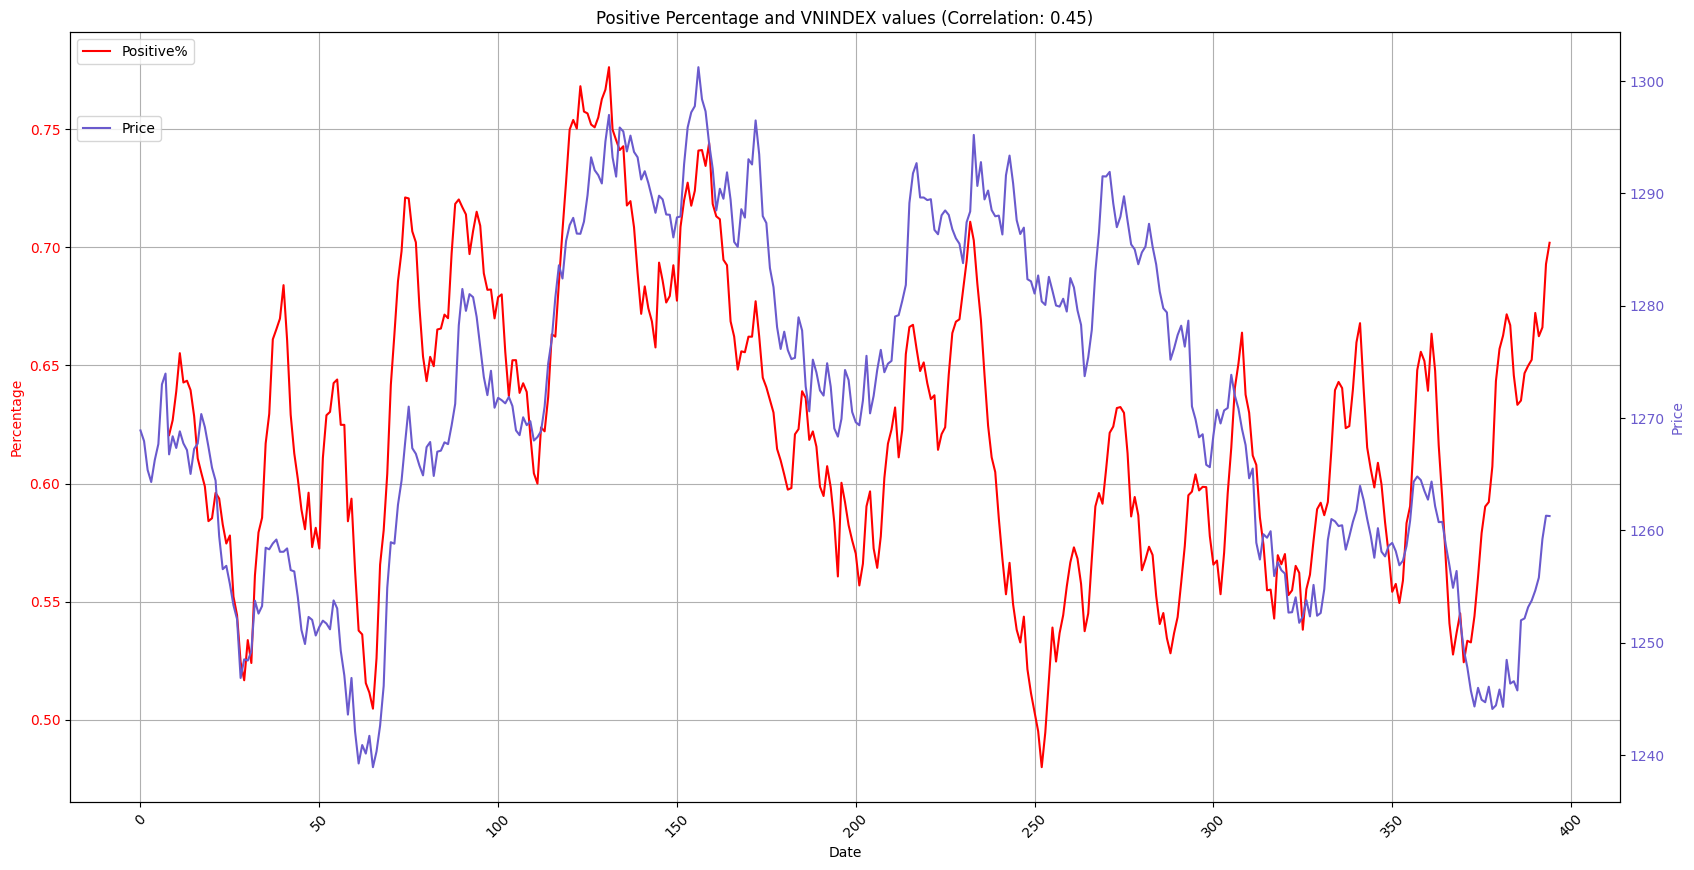

In [7]:
# plot idx is date 
merged_df['plotidx'] = [x for x in range(0, len(merged_df))]

corre1 = merged_df['m_1d_PosPN']
corre2 = merged_df['close']

corr = corre2.corr(corre1)

fig = plt.figure(figsize=(20, 10))
ax = fig.add_subplot()

# Second subplot: Negative Posts with Price
ax.plot(merged_df['plotidx'], corre1, label='Positive%', color='red')
ax.set_title("Positive Percentage and VNINDEX values (Correlation: {:.2f})".format(corr))
ax.set_xlabel('Date')
ax.set_ylabel('Percentage', color='red')
ax.tick_params(axis='y', labelcolor='red')
ax.tick_params(axis='x', rotation=45)
ax.grid(True)

# Add the price line with a secondary y-axis
ax_price = ax.twinx()
ax_price.plot(merged_df['plotidx'], corre2, label='Price', color='Slateblue')
ax_price.set_ylabel('Price', color='Slateblue')
ax_price.tick_params(axis='y', labelcolor='Slateblue')
ax.legend(loc='upper left')
ax_price.legend(loc='upper left', bbox_to_anchor=(0, 0.9))

C:\Users\Loli\AppData\Local\Temp\ipykernel_12176\1606841071.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  plot_df['price_change'] = plot_df['close'].pct_change(periods=9)
C:\Users\Loli\AppData\Local\Temp\ipykernel_12176\1606841071.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  plot_df['pn_change'] = plot_df['m_1d_PosPN'].pct_change(periods=9)


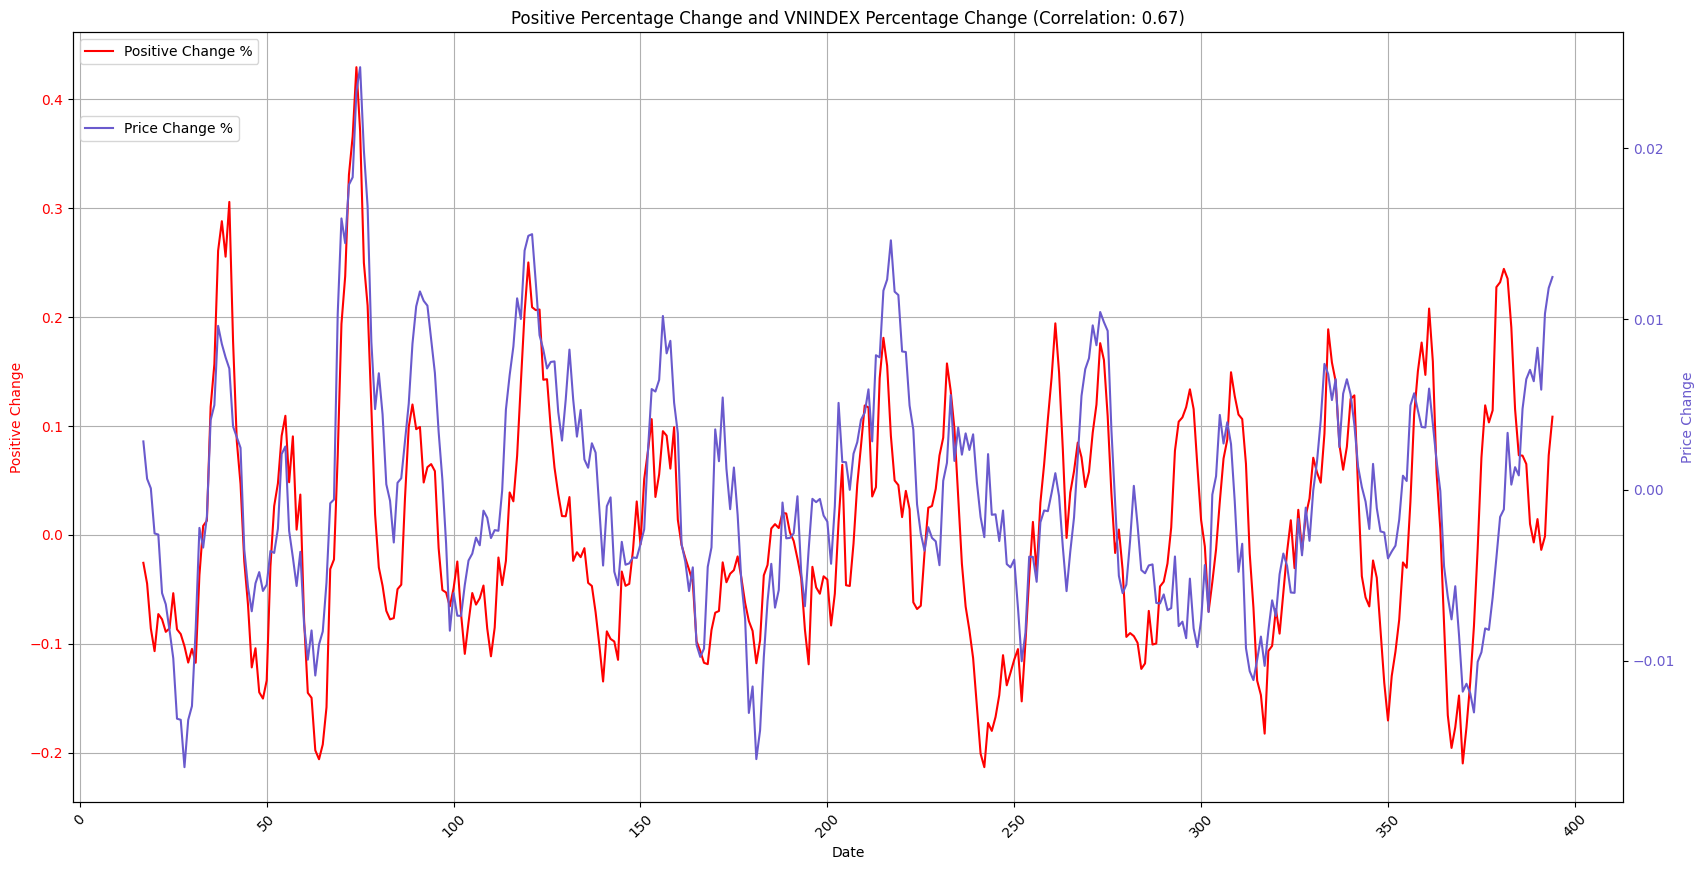

In [8]:
plot_df = merged_df[['date', 'plotidx', 'm_1d_PosPN', 'close']]

plot_df['price_change'] = plot_df['close'].pct_change(periods=9)
plot_df['pn_change'] = plot_df['m_1d_PosPN'].pct_change(periods=9)

plot_df = plot_df.dropna()

fig = plt.figure(figsize=(20, 10))
ax = fig.add_subplot()

corr = plot_df['price_change'].corr(plot_df['pn_change'])

# Second subplot: Negative Posts with Price
ax.set_title("Positive Percentage Change and VNINDEX Percentage Change (Correlation: {:.2f})".format(corr))
ax.plot(plot_df['plotidx'], plot_df['pn_change'], label='Positive Change %', color='red')
ax.set_xlabel('Date')
ax.set_ylabel('Positive Change', color='red')
ax.tick_params(axis='y', labelcolor='red')
ax.tick_params(axis='x', rotation=45)
ax.grid(True)

# Add the price line with a secondary y-axis
ax_price = ax.twinx()
ax_price.plot(plot_df['plotidx'], plot_df['price_change'], label='Price Change %', color='Slateblue')
ax_price.set_ylabel('Price Change', color='Slateblue')
ax_price.tick_params(axis='y', labelcolor='Slateblue')
ax.legend(loc='upper left')
ax_price.legend(loc='upper left', bbox_to_anchor=(0, 0.9))


In [10]:
INCREASE_PERCENTAGE = 0.005

merged_df['min_trade_date'] = merged_df['date'].shift(-18).dt.date
merged_df['min_trade_date'] = merged_df['min_trade_date'].fillna(method='ffill')
merged_df['min_trade_date'] = merged_df['min_trade_date'].apply(lambda x : pd.to_datetime(str(x) + ' 13:00:00'))
merged_df['min_trade_date'] = merged_df['min_trade_date'].dt.tz_localize('Asia/Ho_Chi_Minh')

merged_df['max_trade_date'] = merged_df['date'].shift(-27).dt.date
merged_df['max_trade_date'] = merged_df['max_trade_date'].fillna(method='ffill')
merged_df['max_trade_date'] = merged_df['max_trade_date'].apply(lambda x : pd.to_datetime(str(x) + ' 15:00:00'))
merged_df['max_trade_date'] = merged_df['max_trade_date'].dt.tz_localize('Asia/Ho_Chi_Minh')

# calculate max price from min_trade_date to max_day_trade
merged_df['max_price'] = merged_df.apply(lambda x : merged_df[(merged_df['date'] >= x['min_trade_date']) & (merged_df['date'] <= x['max_trade_date'])]['high'].max(), axis=1)

# if max_price is nan, set it to the last known price
merged_df['max_price'] = merged_df['max_price'].fillna(method='ffill')

# calculate if the price increase by increase percentage
merged_df['price_increase'] = merged_df.apply(lambda x : 1 if x['max_price'] > x['close']*(1 + INCREASE_PERCENTAGE) else 0, axis=1)
# merged_df['price_increase'] = merged_df.apply(lambda x : -1 if x['max_price'] < x['close']*(1 - INCREASE_PERCENTAGE) else x['price_increase'], axis=1)

merged_df.tail(30)

C:\Users\Loli\AppData\Local\Temp\ipykernel_12176\3890055878.py:4: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  merged_df['min_trade_date'] = merged_df['min_trade_date'].fillna(method='ffill')
C:\Users\Loli\AppData\Local\Temp\ipykernel_12176\3890055878.py:9: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  merged_df['max_trade_date'] = merged_df['max_trade_date'].fillna(method='ffill')
C:\Users\Loli\AppData\Local\Temp\ipykernel_12176\3890055878.py:17: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  merged_df['max_price'] = merged_df['max_price'].fillna(method='ffill')


,date,num_PN,positive,negative,neutral,num_CntAll,r_PosPN,r_PosAll,r_NeuAll,m_1d_PN,...,open,high,low,close,volume,plotidx,min_trade_date,max_trade_date,max_price,price_increase
365,2024-11-01 13:30:00+07:00,0,34,34,527,595,0.500000,0.057143,0.885714,9.333333,...,1260.84,1261.32,1257.63,1258.66,74672500,365,2024-11-05 13:00:00+07:00,2024-11-06 15:00:00+07:00,1262.44,0
366,2024-11-01 14:00:00+07:00,-8,52,60,747,859,0.464286,0.060536,0.869616,4.777778,...,1258.76,1258.96,1254.33,1256.88,131247857,366,2024-11-05 13:00:00+07:00,2024-11-06 15:00:00+07:00,1262.44,0
367,2024-11-01 14:30:00+07:00,-3,38,41,502,581,0.481013,0.065404,0.864028,3.222222,...,1256.76,1256.76,1254.89,1254.89,85230500,367,2024-11-05 13:00:00+07:00,2024-11-06 15:00:00+07:00,1262.44,1
368,2024-11-04 09:00:00+07:00,15,28,13,354,395,0.682927,0.070886,0.896203,3.333333,...,1255.06,1256.41,1252.86,1256.39,43024200,368,2024-11-06 13:00:00+07:00,2024-11-06 15:00:00+07:00,1262.44,0
369,2024-11-04 09:30:00+07:00,8,47,39,578,664,0.546512,0.070783,0.870482,4.666667,...,1256.38,1256.96,1250.94,1252.01,87304800,369,2024-11-06 13:00:00+07:00,2024-11-06 15:00:00+07:00,1262.44,1
370,2024-11-04 10:00:00+07:00,-12,47,59,568,674,0.443396,0.069733,0.842730,1.222222,...,1251.92,1251.98,1247.76,1249.41,91837303,370,2024-11-06 13:00:00+07:00,2024-11-06 15:00:00+07:00,1262.44,1
371,2024-11-04 10:30:00+07:00,15,38,23,423,484,0.622951,0.078512,0.873967,2.333333,...,1249.64,1250.15,1247.77,1247.82,47799934,371,2024-11-06 13:00:00+07:00,2024-11-06 15:00:00+07:00,1262.44,1
372,2024-11-04 11:00:00+07:00,4,33,29,404,466,0.532258,0.070815,0.866953,2.333333,...,1247.89,1248.89,1245.72,1245.73,56384350,372,2024-11-06 13:00:00+07:00,2024-11-06 15:00:00+07:00,1262.44,1
373,2024-11-04 13:00:00+07:00,16,41,25,399,465,0.621212,0.088172,0.858065,3.888889,...,1244.96,1246.72,1243.85,1244.33,101301400,373,2024-11-06 13:00:00+07:00,2024-11-06 15:00:00+07:00,1262.44,1
374,2024-11-04 13:30:00+07:00,29,63,34,564,661,0.649485,0.095310,0.853253,7.111111,...,1244.31,1248.59,1242.36,1245.99,136342362,374,2024-11-06 13:00:00+07:00,2024-11-06 15:00:00+07:00,1262.44,1


0.5% profit probability:  0.5316455696202531


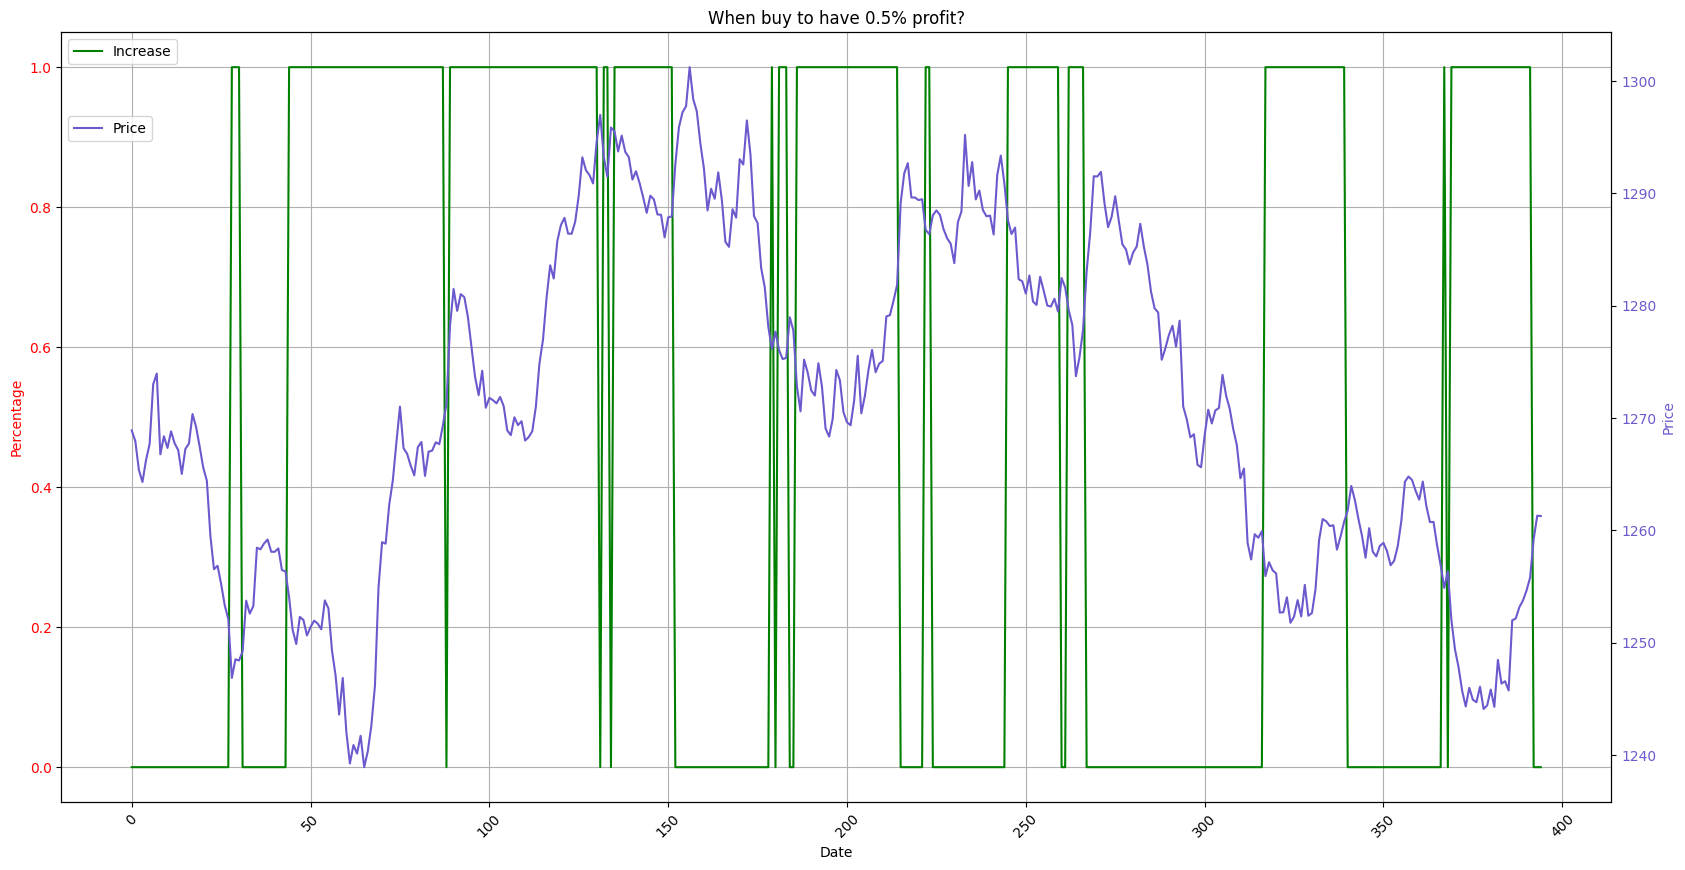

In [11]:
fig = plt.figure(figsize=(20, 10))
ax = fig.add_subplot()

# Second subplot: Negative Posts with Price
ax.plot(merged_df['plotidx'], merged_df['price_increase'], label='Increase', color='green')
ax.set_title(f"When buy to have {INCREASE_PERCENTAGE*100}% profit?")
ax.set_xlabel('Date')
ax.set_ylabel('Percentage', color='red')
ax.tick_params(axis='y', labelcolor='red')
ax.tick_params(axis='x', rotation=45)
ax.grid(True)

# Add the price line with a secondary y-axis
ax_price = ax.twinx()
ax_price.plot(merged_df['plotidx'], merged_df['close'], label='Price', color='Slateblue')
ax_price.set_ylabel('Price', color='Slateblue')
ax_price.tick_params(axis='y', labelcolor='Slateblue')
ax.legend(loc='upper left')
ax_price.legend(loc='upper left', bbox_to_anchor=(0, 0.9))

print(f"{INCREASE_PERCENTAGE*100}% profit probability: ", merged_df[merged_df['price_increase'] > 0]['price_increase'].count() / len(merged_df['price_increase']))

In [35]:
# using sklearn to classify the price increase, using the dataframe merged_df, using logistic regression, and the features are:
# num_PN	positive	negative	neutral	num_CntAll	r_PosPN	r_PosAll	r_NeuAll	m_1d_PN	m_1d_PosPN	m_1d_CntAll	m_2h_PN	m_2h_PosPN	m_2h_CntAll	
# 
# and the target is price_increase
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score

# take only data from 2024-09-09 to 2024-11-01
X = merged_df[merged_df['date'] >= pd.to_datetime('2024-09-09 09:00:00').tz_localize('Asia/Ho_Chi_Minh')]
X = X[X['date'] <= pd.to_datetime('2024-11-01 15:00:00').tz_localize('Asia/Ho_Chi_Minh')]
X = X.reset_index(drop=True)

y = X['price_increase']
X = X.drop(columns=['date', 'min_trade_date', 'max_trade_date', 'max_price', 'price_increase', 'plotidx'])

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15, stratify=y)

print("X_train shape: ", X_train.shape)
print("X_test shape: ", X_test.shape)

model = LogisticRegression(max_iter=2000)
model.fit(X_train, y_train)

y_pred = model.predict(X_test)

print("y_test: ", y_test.values)
print("y_pred: ", y_pred)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
report = classification_report(y_test, y_pred)

print("Accuracy: ", accuracy)
print(report)


X_train shape:  (306, 19)
X_test shape:  (54, 19)
y_test:  [0 1 1 1 0 0 1 1 1 0 0 0 1 0 1 0 0 1 1 1 1 1 0 1 1 0 1 1 1 0 1 1 0 0 1 0 0
 1 0 1 0 0 1 1 1 0 0 0 0 0 1 1 0 0]
y_pred:  [0 0 1 0 0 1 0 1 1 1 0 0 0 0 1 0 0 1 1 1 1 1 1 1 0 0 1 1 1 1 1 0 0 1 1 1 1
 1 1 1 0 1 1 0 1 0 1 1 0 1 0 0 0 1]
Accuracy:  0.5925925925925926
              precision    recall  f1-score   support

           0       0.59      0.50      0.54        26
           1       0.59      0.68      0.63        28

    accuracy                           0.59        54
   macro avg       0.59      0.59      0.59        54
weighted avg       0.59      0.59      0.59        54

